In [1]:
"""
---
title: Sketch RNN
summary: >
  This is an annotated PyTorch implementation of the Sketch RNN from paper A Neural Representation of Sketch Drawings.
  Sketch RNN is a sequence-to-sequence model that generates sketches of objects such as bicycles, cats, etc.
---

# Sketch RNN

This is an annotated [PyTorch](https://pytorch.org) implementation of the paper
[A Neural Representation of Sketch Drawings](https://arxiv.org/abs/1704.03477).

Sketch RNN is a sequence-to-sequence variational auto-encoder.
Both encoder and decoder are recurrent neural network models.
It learns to reconstruct stroke based simple drawings, by predicting
a series of strokes.
Decoder predicts each stroke as a mixture of Gaussian's.

### Getting data
Download data from [Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset).
There is a link to download `npz` files in *Sketch-RNN QuickDraw Dataset* section of the readme.
Place the downloaded `npz` file(s) in `data/sketch` folder.
This code is configured to use `bicycle` dataset.
You can change this in configurations.

### Acknowledgements
Took help from [PyTorch Sketch RNN](https://github.com/alexis-jacq/Pytorch-Sketch-RNN) project by
[Alexis David Jacq](https://github.com/alexis-jacq)
"""

import math
from typing import Optional, Tuple, Any

import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import Dataset, DataLoader

import einops
from labml import lab, experiment, tracker, monit
from labml_helpers.device import DeviceConfigs
from labml_helpers.module import Module
from labml_helpers.optimizer import OptimizerConfigs
from labml_helpers.train_valid import TrainValidConfigs, hook_model_outputs, BatchIndex


class StrokesDataset(Dataset):
    """
    ## Dataset

    This class loads and pre-processes the data.
    """

    def __init__(self, dataset: np.array, max_seq_length: int, scale: Optional[float] = None):
        """
        `dataset` is a list of numpy arrays of shape [seq_len, 3].
        It is a sequence of strokes, and each stroke is represented by
        3 integers.
        First two are the displacements along x and y ($\Delta x$, $\Delta y$)
        and the last integer represents the state of the pen, $1$ if it's touching
        the paper and $0$ otherwise.
        """

        data = []
        # We iterate through each of the sequences and filter
        for seq in dataset:
            # Filter if the length of the sequence of strokes is within our range
            if 10 < len(seq) <= max_seq_length:
                # Clamp $\Delta x$, $\Delta y$ to $[-1000, 1000]$
                seq = np.minimum(seq, 1000)
                seq = np.maximum(seq, -1000)
                # Convert to a floating point array and add to `data`
                seq = np.array(seq, dtype=np.float32)
                data.append(seq)

        # We then calculate the scaling factor which is the
        # standard deviation of ($\Delta x$, $\Delta y$) combined.
        # Paper notes that the mean is not adjusted for simplicity,
        # since the mean is anyway close to $0$.
        if scale is None:
            scale = np.std(np.concatenate([np.ravel(s[:, 0:2]) for s in data]))
        self.scale = scale

        # Get the longest sequence length among all sequences
        longest_seq_len = max([len(seq) for seq in data])

        # We initialize PyTorch data array with two extra steps for start-of-sequence (sos)
        # and end-of-sequence (eos).
        # Each step is a vector $(\Delta x, \Delta y, p_1, p_2, p_3)$.
        # Only one of $p_1, p_2, p_3$ is $1$ and the others are $0$.
        # They represent *pen down*, *pen up* and *end-of-sequence* in that order.
        # $p_1$ is $1$ if the pen touches the paper in the next step.
        # $p_2$ is $1$ if the pen doesn't touch the paper in the next step.
        # $p_3$ is $1$ if it is the end of the drawing.
        self.data = torch.zeros(len(data), longest_seq_len + 2, 5, dtype=torch.float)
        # The mask array needs only one extra-step since it is for the outputs of the
        # decoder, which takes in `data[:-1]` and predicts next step.
        self.mask = torch.zeros(len(data), longest_seq_len + 1)

        for i, seq in enumerate(data):
            seq = torch.from_numpy(seq)
            len_seq = len(seq)
            # Scale and set $\Delta x, \Delta y$
            self.data[i, 1:len_seq + 1, :2] = seq[:, :2] / scale
            # $p_1$
            self.data[i, 1:len_seq + 1, 2] = 1 - seq[:, 2]
            # $p_2$
            self.data[i, 1:len_seq + 1, 3] = seq[:, 2]
            # $p_3$
            self.data[i, len_seq + 1:, 4] = 1
            # Mask is on until end of sequence
            self.mask[i, :len_seq + 1] = 1

        # Start-of-sequence is $(0, 0, 1, 0, 0)$
        self.data[:, 0, 2] = 1

    def __len__(self):
        """Size of the dataset"""
        return len(self.data)

    def __getitem__(self, idx: int):
        """Get a sample"""
        return self.data[idx], self.mask[idx]


class BivariateGaussianMixture:
    """
    ## Bi-variate Gaussian mixture

    The mixture is represented by $\Pi$ and
    $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$.
    This class adjusts temperatures and creates the categorical and Gaussian
    distributions from the parameters.
    """

    def __init__(self, pi_logits: torch.Tensor, mu_x: torch.Tensor, mu_y: torch.Tensor,
                 sigma_x: torch.Tensor, sigma_y: torch.Tensor, rho_xy: torch.Tensor):
        self.pi_logits = pi_logits
        self.mu_x = mu_x
        self.mu_y = mu_y
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.rho_xy = rho_xy

    @property
    def n_distributions(self):
        """Number of distributions in the mixture, $M$"""
        return self.pi_logits.shape[-1]

    def set_temperature(self, temperature: float):
        """
        Adjust by temperature $\tau$
        """
        # $$\hat{\Pi_k} \leftarrow \frac{\hat{\Pi_k}}{\tau}$$
        self.pi_logits /= temperature
        # $$\sigma^2_x \leftarrow \sigma^2_x \tau$$
        self.sigma_x *= math.sqrt(temperature)
        # $$\sigma^2_y \leftarrow \sigma^2_y \tau$$
        self.sigma_y *= math.sqrt(temperature)

    def get_distribution(self):
        # Clamp $\sigma_x$, $\sigma_y$ and $\rho_{xy}$ to avoid getting `NaN`s
        sigma_x = torch.clamp_min(self.sigma_x, 1e-5)
        sigma_y = torch.clamp_min(self.sigma_y, 1e-5)
        rho_xy = torch.clamp(self.rho_xy, -1 + 1e-5, 1 - 1e-5)

        # Get means
        mean = torch.stack([self.mu_x, self.mu_y], -1)
        # Get covariance matrix
        cov = torch.stack([
            sigma_x * sigma_x, rho_xy * sigma_x * sigma_y,
            rho_xy * sigma_x * sigma_y, sigma_y * sigma_y
        ], -1)
        cov = cov.view(*sigma_y.shape, 2, 2)

        # Create bi-variate normal distribution.
        #
        # 📝 It would be efficient to `scale_tril` matrix as `[[a, 0], [b, c]]`
        # where
        # $$a = \sigma_x, b = \rho_{xy} \sigma_y, c = \sigma_y \sqrt{1 - \rho^2_{xy}}$$.
        # But for simplicity we use co-variance matrix.
        # [This is a good resource](https://www2.stat.duke.edu/courses/Spring12/sta104.1/Lectures/Lec22.pdf)
        # if you want to read up more about bi-variate distributions, their co-variance matrix,
        # and probability density function.
        multi_dist = torch.distributions.MultivariateNormal(mean, covariance_matrix=cov)

        # Create categorical distribution $\Pi$ from logits
        cat_dist = torch.distributions.Categorical(logits=self.pi_logits)

        #
        return cat_dist, multi_dist



In [2]:

class EncoderRNN(Module):
    """
    ## Encoder module

    This consists of a bidirectional LSTM
    """

    def __init__(self, d_z: int, enc_hidden_size: int):
        super().__init__()
        # Create a bidirectional LSTM taking a sequence of
        # $(\Delta x, \Delta y, p_1, p_2, p_3)$ as input.
        # self.lstm = nn.LSTM(5, enc_hidden_size, bidirectional=True)
        self.lstm = nn.LSTM(5, enc_hidden_size)
        # self.lstm = nn.LSTM(5, enc_hidden_size)
        # Head to get $\mu$
        # self.mu_head = nn.Linear(2 * enc_hidden_size, d_z)
        self.mu_head = nn.Linear(enc_hidden_size, d_z)
        # Head to get $\hat{\sigma}$
        # self.sigma_head = nn.Linear(2 * enc_hidden_size, d_z)
        self.sigma_head = nn.Linear(enc_hidden_size, d_z)

    def forward(self, inputs: torch.Tensor, state=None):
        # The hidden state of the bidirectional LSTM is the concatenation of the
        # output of the last token in the forward direction and
        # first token in the reverse direction, which is what we want.
        # $$h_{\rightarrow} = encode_{\rightarrow}(S),
        # h_{\leftarrow} = encode←_{\leftarrow}(S_{reverse}),
        # h = [h_{\rightarrow}; h_{\leftarrow}]$$
        
        _, (hidden, cell) = self.lstm(inputs.float(), state)
        
        # The state has shape `[2, batch_size, hidden_size]`,
        # where the first dimension is the direction.
        # We rearrange it to get $h = [h_{\rightarrow}; h_{\leftarrow}]$
        # hidden = einops.rearrange(hidden, 'fb b h -> b (fb h)')
        hidden = hidden.squeeze(0)

        # $\mu$
        mu = self.mu_head(hidden)
        # $\hat{\sigma}$
        sigma_hat = self.sigma_head(hidden)
        # $\sigma = \exp(\frac{\hat{\sigma}}{2})$
        sigma = torch.exp(sigma_hat / 2.)

        # Sample $z = \mu + \sigma \cdot \mathcal{N}(0, I)$
        z = mu + sigma * torch.normal(mu.new_zeros(mu.shape), mu.new_ones(mu.shape))

        #
        return z, mu, sigma_hat

In [13]:
class DecoderRNN(Module):
    """
    ## Decoder module

    This consists of a LSTM
    """

    def __init__(self, d_z: int, dec_hidden_size: int, n_distributions: int):
        super().__init__()
        # LSTM takes $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$ as input
        self.lstm = nn.LSTM(d_z + 5, dec_hidden_size)

        # Initial state of the LSTM is $[h_0; c_0] = \tanh(W_{z}z + b_z)$.
        # `init_state` is the linear transformation for this
        self.init_state = nn.Linear(d_z, 2 * dec_hidden_size)

        # This layer produces outputs for each of the `n_distributions`.
        # Each distribution needs six parameters
        # $(\hat{\Pi_i}, \mu_{x_i}, \mu_{y_i}, \hat{\sigma_{x_i}}, \hat{\sigma_{y_i}} \hat{\rho_{xy_i}})$
        self.mixtures = nn.Linear(dec_hidden_size, 6 * n_distributions)

        # This head is for the logits $(\hat{q_1}, \hat{q_2}, \hat{q_3})$
        self.q_head = nn.Linear(dec_hidden_size, 3)
        # This is to calculate $\log(q_k)$ where
        # $$q_k = \operatorname{softmax}(\hat{q})_k = \frac{\exp(\hat{q_k})}{\sum_{j = 1}^3 \exp(\hat{q_j})}$$
        self.q_log_softmax = nn.LogSoftmax(-1)

        # These parameters are stored for future reference
        self.n_distributions = n_distributions
        self.dec_hidden_size = dec_hidden_size

    def forward(self, x: torch.Tensor, z: torch.Tensor, state: Optional[Tuple[torch.Tensor, torch.Tensor]]):
        # Calculate the initial state
        if state is None:
            # $[h_0; c_0] = \tanh(W_{z}z + b_z)$
            
            print(self.init_state(z).shape, "init z state")
            h, c = torch.split(torch.tanh(self.init_state(z)), self.dec_hidden_size, 1)
            # `h` and `c` have shapes `[batch_size, lstm_size]`. We want to shape them
            # to `[1, batch_size, lstm_size]` because that's the shape used in LSTM.
            state = (h.unsqueeze(0).contiguous(), c.unsqueeze(0).contiguous())
            
            print('state', state[0].shape, state[1].shape)
            # state is the state passed from the previous step (or encoder)

        # Run the LSTM
        outputs, state = self.lstm(x, state)

        # Get $\log(q)$
        q_logits = self.q_log_softmax(self.q_head(outputs))

        # Get $(\hat{\Pi_i}, \mu_{x,i}, \mu_{y,i}, \hat{\sigma_{x,i}},
        # \hat{\sigma_{y,i}} \hat{\rho_{xy,i}})$.
        # `torch.split` splits the output into 6 tensors of size `self.n_distribution`
        # across dimension `2`.
        pi_logits, mu_x, mu_y, sigma_x, sigma_y, rho_xy = \
            torch.split(self.mixtures(outputs), self.n_distributions, 2)

        # Create a bi-variate Gaussian mixture
        # $\Pi$ and 
        # $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$
        # where
        # $$\sigma_{x,i} = \exp(\hat{\sigma_{x,i}}), \sigma_{y,i} = \exp(\hat{\sigma_{y,i}}),
        # \rho_{xy,i} = \tanh(\hat{\rho_{xy,i}})$$
        # and
        # $$\Pi_i = \operatorname{softmax}(\hat{\Pi})_i = \frac{\exp(\hat{\Pi_i})}{\sum_{j = 1}^3 \exp(\hat{\Pi_j})}$$
        #
        # $\Pi$ is the categorical probabilities of choosing the distribution out of the mixture
        # $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$.
        dist = BivariateGaussianMixture(pi_logits, mu_x, mu_y,
                                        torch.exp(sigma_x), torch.exp(sigma_y), torch.tanh(rho_xy))

        #
        return dist, q_logits, state



In [14]:
class ReconstructionLoss(Module):
    """
    ## Reconstruction Loss
    """

    def forward(self, mask: torch.Tensor, target: torch.Tensor,
                 dist: 'BivariateGaussianMixture', q_logits: torch.Tensor):
        # Get $\Pi$ and $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$
        pi, mix = dist.get_distribution()
        # `target` has shape `[seq_len, batch_size, 5]` where the last dimension is the features
        # $(\Delta x, \Delta y, p_1, p_2, p_3)$.
        # We want to get $\Delta x, \Delta$ y and get the probabilities from each of the distributions
        # in the mixture $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$.
        #
        # `xy` will have shape `[seq_len, batch_size, n_distributions, 2]`
        xy = target[:, :, 0:2].unsqueeze(-2).expand(-1, -1, dist.n_distributions, -1)
        # Calculate the probabilities
        # $$p(\Delta x, \Delta y) =
        # \sum_{j=1}^M \Pi_j \mathcal{N} \big( \Delta x, \Delta y \vert
        # \mu_{x,j}, \mu_{y,j}, \sigma_{x,j}, \sigma_{y,j}, \rho_{xy,j}
        # \big)$$
        probs = torch.sum(pi.probs * torch.exp(mix.log_prob(xy)), 2)

        # $$L_s = - \frac{1}{N_{max}} \sum_{i=1}^{N_s} \log \big (p(\Delta x, \Delta y) \big)$$
        # Although `probs` has $N_{max}$ (`longest_seq_len`) elements, the sum is only taken
        # upto $N_s$ because the rest is masked out.
        #
        # It might feel like we should be taking the sum and dividing by $N_s$ and not $N_{max}$,
        # but this will give higher weight for individual predictions in shorter sequences.
        # We give equal weight to each prediction $p(\Delta x, \Delta y)$ when we divide by $N_{max}$
        loss_stroke = -torch.mean(mask * torch.log(1e-5 + probs))

        # $$L_p = - \frac{1}{N_{max}} \sum_{i=1}^{N_{max}} \sum_{k=1}^{3} p_{k,i} \log(q_{k,i})$$
        loss_pen = -torch.mean(target[:, :, 2:] * q_logits)

        # $$L_R = L_s + L_p$$
        return loss_stroke + loss_pen


In [15]:
class KLDivLoss(Module):
    """
    ## KL-Divergence loss

    This calculates the KL divergence between a given normal distribution and $\mathcal{N}(0, 1)$
    """

    def forward(self, sigma_hat: torch.Tensor, mu: torch.Tensor):
        # $$L_{KL} = - \frac{1}{2 N_z} \bigg( 1 + \hat{\sigma} - \mu^2 - \exp(\hat{\sigma}) \bigg)$$
        return -0.5 * torch.mean(1 + sigma_hat - mu ** 2 - torch.exp(sigma_hat))



In [16]:

class Sampler:
    """
    ## Sampler

    This samples a sketch from the decoder and plots it
    """

    def __init__(self, encoder: EncoderRNN, decoder: DecoderRNN):
        self.decoder = decoder
        self.encoder = encoder

    def sample(self, data: torch.Tensor, temperature: float):
        # $N_{max}$
        longest_seq_len = len(data)

        # Get $z$ from the encoder
        z, _, _ = self.encoder(data)

        # Start-of-sequence stroke is $(0, 0, 1, 0, 0)$
        s = data.new_tensor([0, 0, 1, 0, 0])
        seq = [s]
        # Initial decoder is `None`.
        # The decoder will initialize it to $[h_0; c_0] = \tanh(W_{z}z + b_z)$
        state = None

        # We don't need gradients
        with torch.no_grad():
            # Sample $N_{max}$ strokes
            for i in range(longest_seq_len):
                # $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$ is the input to the decoder
                data = torch.cat([s.view(1, 1, -1), z.unsqueeze(0)], 2)
                # Get $\Pi$, $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$,
                # $q$ and the next state from the decoder
                dist, q_logits, state = self.decoder(data, z, state)
                # Sample a stroke
                s = self._sample_step(dist, q_logits, temperature)
                # Add the new stroke to the sequence of strokes
                seq.append(s)
                # Stop sampling if $p_3 = 1$. This indicates that sketching has stopped
                if s[4] == 1:
                    break

        # Create a PyTorch tensor of the sequence of strokes
        seq = torch.stack(seq)

        # Plot the sequence of strokes
        self.plot(seq)

    @staticmethod
    def _sample_step(dist: 'BivariateGaussianMixture', q_logits: torch.Tensor, temperature: float):
        # Set temperature $\tau$ for sampling. This is implemented in class `BivariateGaussianMixture`.
        dist.set_temperature(temperature)
        # Get temperature adjusted $\Pi$ and $\mathcal{N}(\mu_{x}, \mu_{y}, \sigma_{x}, \sigma_{y}, \rho_{xy})$
        pi, mix = dist.get_distribution()
        # Sample from $\Pi$ the index of the distribution to use from the mixture
        idx = pi.sample()[0, 0]

        # Create categorical distribution $q$ with log-probabilities `q_logits` or $\hat{q}$
        q = torch.distributions.Categorical(logits=q_logits / temperature)
        # Sample from $q$
        q_idx = q.sample()[0, 0]

        # Sample from the normal distributions in the mixture and pick the one indexed by `idx`
        xy = mix.sample()[0, 0, idx]

        # Create an empty stroke $(\Delta x, \Delta y, q_1, q_2, q_3)$
        stroke = q_logits.new_zeros(5)
        # Set $\Delta x, \Delta y$
        stroke[:2] = xy
        # Set $q_1, q_2, q_3$
        stroke[q_idx + 2] = 1
        #
        return stroke

    @staticmethod
    def plot(seq: torch.Tensor):
        # Take the cumulative sums of $(\Delta x, \Delta y)$ to get $(x, y)$
        seq[:, 0:2] = torch.cumsum(seq[:, 0:2], dim=0)
        # Create a new numpy array of the form $(x, y, q_2)$
        seq[:, 2] = seq[:, 3]
        seq = seq[:, 0:3].detach().cpu().numpy()

        # Split the array at points where $q_2$ is $1$.
        # i.e. split the array of strokes at the points where the pen is lifted from the paper.
        # This gives a list of sequence of strokes.
        strokes = np.split(seq, np.where(seq[:, 2] > 0)[0] + 1)
        # Plot each sequence of strokes
        for s in strokes:
            plt.plot(s[:, 0], -s[:, 1])
        # Don't show axes
        plt.axis('off')
        # Show the plot
        plt.show()


torch.Size([1, 1024]) init z state
state torch.Size([1, 1, 512]) torch.Size([1, 1, 512])


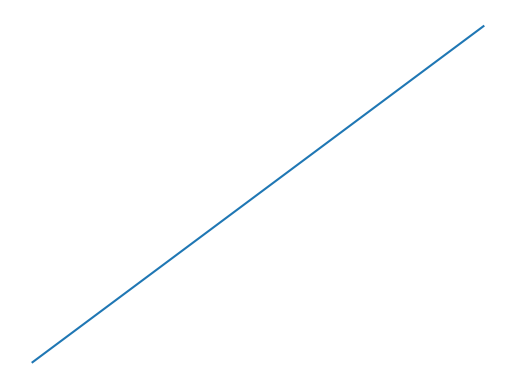

torch.Size([117, 4, 133]) inputs
torch.Size([4, 128]) z
torch.Size([4, 1024]) init z state
state torch.Size([1, 4, 512]) torch.Size([1, 4, 512])
torch.Size([117, 4, 133]) inputs
torch.Size([4, 128]) z
torch.Size([4, 1024]) init z state
state torch.Size([1, 4, 512]) torch.Size([1, 4, 512])
torch.Size([117, 4, 133]) inputs
torch.Size([4, 128]) z
torch.Size([4, 1024]) init z state
state torch.Size([1, 4, 512]) torch.Size([1, 4, 512])
torch.Size([117, 4, 133]) inputs
torch.Size([4, 128]) z
torch.Size([4, 1024]) init z state
state torch.Size([1, 4, 512]) torch.Size([1, 4, 512])
torch.Size([117, 4, 133]) inputs
torch.Size([4, 128]) z
torch.Size([4, 1024]) init z state
state torch.Size([1, 4, 512]) torch.Size([1, 4, 512])
torch.Size([117, 4, 133]) inputs
torch.Size([4, 128]) z
torch.Size([4, 1024]) init z state
state torch.Size([1, 4, 512]) torch.Size([1, 4, 512])
torch.Size([117, 4, 133]) inputs
torch.Size([4, 128]) z
torch.Size([4, 1024]) init z state
state torch.Size([1, 4, 512]) torch.Siz

KeyboardInterrupt: 

In [17]:
class Configs(TrainValidConfigs):
    """
    ## Configurations

    These are default configurations which can later be adjusted by passing a `dict`.
    """

    # Device configurations to pick the device to run the experiment
    device: torch.device = DeviceConfigs()
    #
    encoder: EncoderRNN
    decoder: DecoderRNN
    optimizer: optim.Adam
    sampler: Sampler

    dataset_name: str
    train_loader: DataLoader
    valid_loader: DataLoader
    train_dataset: StrokesDataset
    valid_dataset: StrokesDataset

    # Encoder and decoder sizes
    enc_hidden_size = 256
    dec_hidden_size = 512

    # Batch size
    batch_size = 4

    # Number of features in $z$
    d_z = 128
    # Number of distributions in the mixture, $M$
    n_distributions = 20

    # Weight of KL divergence loss, $w_{KL}$
    kl_div_loss_weight = 0.5
    # Gradient clipping
    grad_clip = 1.
    # Temperature $\tau$ for sampling
    temperature = 0.4

    # Filter out stroke sequences longer than $200$
    max_seq_length = 200

    epochs = 1 

    kl_div_loss = KLDivLoss()
    reconstruction_loss = ReconstructionLoss()

    def init(self):
        # Initialize encoder & decoder
        self.encoder = EncoderRNN(self.d_z, self.enc_hidden_size).to(self.device)
        self.decoder = DecoderRNN(self.d_z, self.dec_hidden_size, self.n_distributions).to(self.device)

        # Set optimizer. Things like type of optimizer and learning rate are configurable
        optimizer = OptimizerConfigs()
        optimizer.parameters = list(self.encoder.parameters()) + list(self.decoder.parameters())
        self.optimizer = optimizer

        # Create sampler
        self.sampler = Sampler(self.encoder, self.decoder)

        # `npz` file path is `data/sketch/[DATASET NAME].npz`
        path = lab.get_data_path() / 'sketch' / f'{self.dataset_name}.npz'
        # Load the numpy file
        dataset = np.load(str(path), encoding='latin1', allow_pickle=True)

        # Create training dataset
        self.train_dataset = StrokesDataset(dataset['train'], self.max_seq_length)
        # Create validation dataset
        self.valid_dataset = StrokesDataset(dataset['valid'], self.max_seq_length, self.train_dataset.scale)

        # Create training data loader
        self.train_loader = DataLoader(self.train_dataset, self.batch_size, shuffle=True)
        # Create validation data loader
        self.valid_loader = DataLoader(self.valid_dataset, self.batch_size)

        # Add hooks to monitor layer outputs on Tensorboard
        hook_model_outputs(self.mode, self.encoder, 'encoder')
        hook_model_outputs(self.mode, self.decoder, 'decoder')

        # Configure the tracker to print the total train/validation loss
        tracker.set_scalar("loss.total.*", True)

        self.state_modules = []

    def step(self, batch: Any, batch_idx: BatchIndex):
        self.encoder.train(self.mode.is_train)
        self.decoder.train(self.mode.is_train)

        # Move `data` and `mask` to device and swap the sequence and batch dimensions.
        # `data` will have shape `[seq_len, batch_size, 5]` and
        # `mask` will have shape `[seq_len, batch_size]`.
        data = batch[0].to(self.device).transpose(0, 1)
        mask = batch[1].to(self.device).transpose(0, 1)

        # Increment step in training mode
        if self.mode.is_train:
            tracker.add_global_step(len(data))

        # Encode the sequence of strokes
        with monit.section("encoder"):
            # Get $z$, $\mu$, and $\hat{\sigma}$
            z, mu, sigma_hat = self.encoder(data)

        # Decode the mixture of distributions and $\hat{q}$
        with monit.section("decoder"):
            # Concatenate $[(\Delta x, \Delta y, p_1, p_2, p_3); z]$
            z_stack = z.unsqueeze(0).expand(data.shape[0] - 1, -1, -1)
            inputs = torch.cat([data[:-1], z_stack], 2)
            print(inputs.shape, "inputs")
            print(z.shape, "z")
            # Get mixture of distributions and $\hat{q}$
            dist, q_logits, _ = self.decoder(inputs, z, None)

        # Compute the loss
        with monit.section('loss'):
            # $L_{KL}$
            kl_loss = self.kl_div_loss(sigma_hat, mu)
            # $L_R$
            reconstruction_loss = self.reconstruction_loss(mask, data[1:], dist, q_logits)
            # $Loss = L_R + w_{KL} L_{KL}$
            loss = reconstruction_loss + self.kl_div_loss_weight * kl_loss

            # Track losses
            tracker.add("loss.kl.", kl_loss)
            tracker.add("loss.reconstruction.", reconstruction_loss)
            tracker.add("loss.total.", loss)

        # Only if we are in training state
        if self.mode.is_train:
            # Run optimizer
            with monit.section('optimize'):
                # Set `grad` to zero
                self.optimizer.zero_grad()
                # Compute gradients
                loss.backward()
                # Log model parameters and gradients
                if batch_idx.is_last:
                    tracker.add(encoder=self.encoder, decoder=self.decoder)
                # Clip gradients
                nn.utils.clip_grad_norm_(self.encoder.parameters(), self.grad_clip)
                nn.utils.clip_grad_norm_(self.decoder.parameters(), self.grad_clip)
                # Optimize
                self.optimizer.step()

        tracker.save()

    def sample(self):
        # Randomly pick a sample from validation dataset to encoder
        data, *_ = self.valid_dataset[np.random.choice(len(self.valid_dataset))]
        # Add batch dimension and move it to device
        data = data.unsqueeze(1).to(self.device)
        # Sample
        self.sampler.sample(data, self.temperature)


def main():
    configs = Configs()
    experiment.create(name="sketch_rnn")

    # Pass a dictionary of configurations
    experiment.configs(configs, {
        'optimizer.optimizer': 'Adam',
        # We use a learning rate of `1e-3` because we can see results faster.
        # Paper had suggested `1e-4`.
        'optimizer.learning_rate': 1e-3,
        # Name of the dataset
        'dataset_name': 'bicycle',
        # Number of inner iterations within an epoch to switch between training, validation and sampling.
        'inner_iterations': 10
    })

    with experiment.start():
        # Run the experiment
        configs.run()


if __name__ == "__main__":
    main()